# Load Dataset

In [6]:
import numpy as np
import cv2
import os

In [7]:
dir = '../../dataset/trainingSample/trainingSample/'
images = []
labels = []
for label in os.listdir(dir):
    for image in os.listdir(dir + label + '/'):
        images.append(cv2.imread(dir + label + '/' + image, cv2.IMREAD_GRAYSCALE) / 255.)
        labels.append(int(label))
images = np.array(images)
images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)
labels = np.array(labels)
labels = labels.reshape(labels.shape[0], 1)

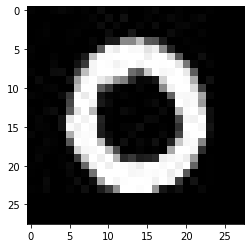

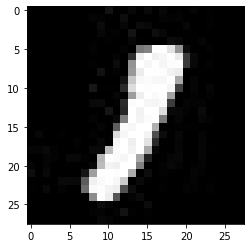

In [8]:
import matplotlib.pyplot as plt

plt.imshow(images[0].reshape(28, 28), cmap='gray')
plt.show()
plt.imshow(images[100].reshape(28, 28), cmap='gray')
plt.show()

# Split Dataset

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True)

# Create model

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model

In [7]:
def create_model():
    input_image = Input(shape=(28, 28, 1))
    
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_image)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Flatten()(x)
    x = layers.Dense(10)(x)
    
    model = Model(input_image, x)
    
    return model

In [8]:
model = create_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

# Training model

In [10]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [11]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=1000, 
          validation_data=(X_test, y_test), 
          batch_size=16,
          shuffle=True,
          verbose=0,
          callbacks=[tensorboard_callback])

# Start Tensorboard

In [ ]:
!taskkill /im tensorboard.exe /f
!del /q %TMP%\.tensorboard-info\*
%reload_ext tensorboard
%tensorboard --logdir logs --host 127.0.0.1 --port 6066

成功: 處理程序 "tensorboard.exe" (PID 2512) 已經終止了。


Launching TensorBoard...

# Testing model

In [13]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 1.3816 - accuracy: 0.8833


[1.3816100358963013, 0.8833333253860474]

In [14]:
print(model.predict(images[0].reshape(1, 28, 28, 1)))
print(np.argmax(model.predict(images[0].reshape(1, 28, 28, 1)), axis=1))

[[ -17.019903 -159.3101    -59.93164   -60.580505 -111.14244   -55.706707
   -71.02482   -89.165474  -72.828606  -57.711723]]
[0]


# Save model

In [15]:
tf.saved_model.save(model, 'save_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save_model\assets


# Load model

In [16]:
new_model = tf.keras.models.load_model('save_model')

In [17]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

In [18]:
print(np.argmax(new_model.predict(images[0].reshape(1, 28, 28, 1)), axis=1))

[0]


In [19]:
new_model.predict(images[0].reshape(1, 28, 28, 1))

array([[ -17.019903, -159.3101  ,  -59.93164 ,  -60.580505, -111.14244 ,
         -55.706707,  -71.02482 ,  -89.165474,  -72.828606,  -57.711723]],
      dtype=float32)

# Save Frezon model

In [20]:
# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: new_model(x))
full_model = full_model.get_concrete_function(
    x=tf.TensorSpec(new_model.inputs[0].shape, new_model.inputs[0].dtype))

In [21]:
# Get frozen ConcreteFunction
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
frozen_func = convert_variables_to_constants_v2(full_model)

In [22]:
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)

--------------------------------------------------
Frozen model layers: 
x
model/conv2d/Conv2D/ReadVariableOp/resource
model/conv2d/Conv2D/ReadVariableOp
model/conv2d/Conv2D
model/conv2d/BiasAdd/ReadVariableOp/resource
model/conv2d/BiasAdd/ReadVariableOp
model/conv2d/BiasAdd
model/conv2d/Relu
model/max_pooling2d/MaxPool
model/conv2d_1/Conv2D/ReadVariableOp/resource
model/conv2d_1/Conv2D/ReadVariableOp
model/conv2d_1/Conv2D
model/conv2d_1/BiasAdd/ReadVariableOp/resource
model/conv2d_1/BiasAdd/ReadVariableOp
model/conv2d_1/BiasAdd
model/conv2d_1/Relu
model/max_pooling2d_1/MaxPool
model/conv2d_2/Conv2D/ReadVariableOp/resource
model/conv2d_2/Conv2D/ReadVariableOp
model/conv2d_2/Conv2D
model/conv2d_2/BiasAdd/ReadVariableOp/resource
model/conv2d_2/BiasAdd/ReadVariableOp
model/conv2d_2/BiasAdd
model/conv2d_2/Relu
model/max_pooling2d_2/MaxPool
model/flatten/Const
model/flatten/Reshape
model/dense/MatMul/ReadVariableOp/resource
model/dense/MatMul/ReadVariableOp
model/dense/MatMul
model/dense/Bi

In [23]:
print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

--------------------------------------------------
Frozen model inputs: 
[<tf.Tensor 'x:0' shape=(None, 28, 28, 1) dtype=float32>]
Frozen model outputs: 
[<tf.Tensor 'Identity:0' shape=(None, 10) dtype=float32>]


In [24]:
# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="simple_frozen_graph.pb",
                  as_text=False)

'./frozen_models\\simple_frozen_graph.pb'